# Predictive Analysis of Heart Disease Dataset

## Introduction

In the United States, heart disease is the leading cause of death in both men and women. Coronary heart disease occurs when the arteries struggle to supply oxygen and nutrient-rich blood to the heart. The most common cause is the buildup of fatty, cholesterol-containing plaques along the arteries, narrowing blood passage to the heart. Angina is a type of chest pain which is a common symptom in patients with heart disease. When blood flow to the heart is severely reduced or completely blocked when plaques dislodge and flow into smaller coronary arteries, it results in a heart attack. Therefore, early detection of heart disease is extremely important for patients.

For this project, I am investigating whether a patient will be diagnosed with heart disease. More precisely, can chest pain type, max heart rate, and exercise-induced angina accurately predict the presence of heart disease in patients?

To answer this question, a heart disease dataset from the Cleveland database will be analyzed. The database originally contains 76 attributes but the dataset contains 14 attributes. The dataset consists of both integer and categorical variables. The target variable is the diagnosis of heart disease which has a range of 0-5. A value of 0 indicates no heart disease and values between 1-4 indicate the presence of heart disease.

## Methods

To answer this question, I have create a model using the K-Nearest Neighbors algorithm that can classify data into two categories, No Heart Disease vs. Has Heart Disease. The predictors I used are chest pain type, max heart rate, exercise-induced angina, sex, and age. The data was split into training and testing datasets, and standardized separately to ensure that the testing data does not influence model training. Cross-validation was used to optimize the hyperparameter K, to minimize model overfitting and underfitting. Since the model is predicting whether patient have heart disease, high recall is important to ensure that false negatives are minimized. For this data analysis, accuracy and recall were both considered when picking a value of K, specifically looking for values that have high accuracy and high recall. Once K was determined, a new model was made using the entire training dataset. The final model was used to predict the classification of the testing dataset and model performance was assess again using accuracy and recall.

One way to visualize the results would be a table that lists the accuracy, precision, and recall of the test data predictions. Additionally, this information can be visualized by plotting each data point and mapping the border between positive or negative predictions based on our model.

In [1]:
library(tidyverse)
library(tidymodels)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
url <- "https://raw.githubusercontent.com/deenahl/dsci-100-2024s-project/main/data/heart_disease/processed.cleveland.data"
data <- read_delim(url, delim=",", col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs","restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"))
# categorical_variables <- c("sex", "cp", "exang", "target")
# integer_variables <- c("age", "thalach")

heart_disease_ds <- data |>
    select(age, sex, cp, exang, thalach, target) |>
    mutate(
        target = as_factor(target),
        target = fct_recode(target, "No Heart Disease"="0", "Has Heart Disease"="1", "Has Heart Disease"="2", "Has Heart Disease"="3", "Has Heart Disease"="4"))

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
set.seed(2019)

hd_split <- initial_split(heart_disease_ds, prop = 0.70, strata = target)
hd_train <- training(hd_split) 
hd_test <- testing(hd_split) 

target_table <- hd_train |>
                group_by(target) |>
                summarize(count = n())
                # mutate(target = fct_recode(target, "No Heart Disease"="0", "Has Heart Disease"="1"))

missing_data <- hd_train |>
                rowwise() |>
                mutate(missing = any(is.na(c(age, sex, cp, exang, thalach, target)))) |>
                filter(missing == TRUE)

predictor_stats <- hd_train |>
                    summarize(mean_age = mean(age), 
                              mean_thalach = mean(thalach))

# summary_tables    
target_table
missing_data
predictor_stats

target,count
<fct>,<int>
No Heart Disease,114
Has Heart Disease,97


age,sex,cp,exang,thalach,target,missing
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>


mean_age,mean_thalach
<dbl>,<dbl>
54.19905,149.7156


Warning message in geom_histogram(stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


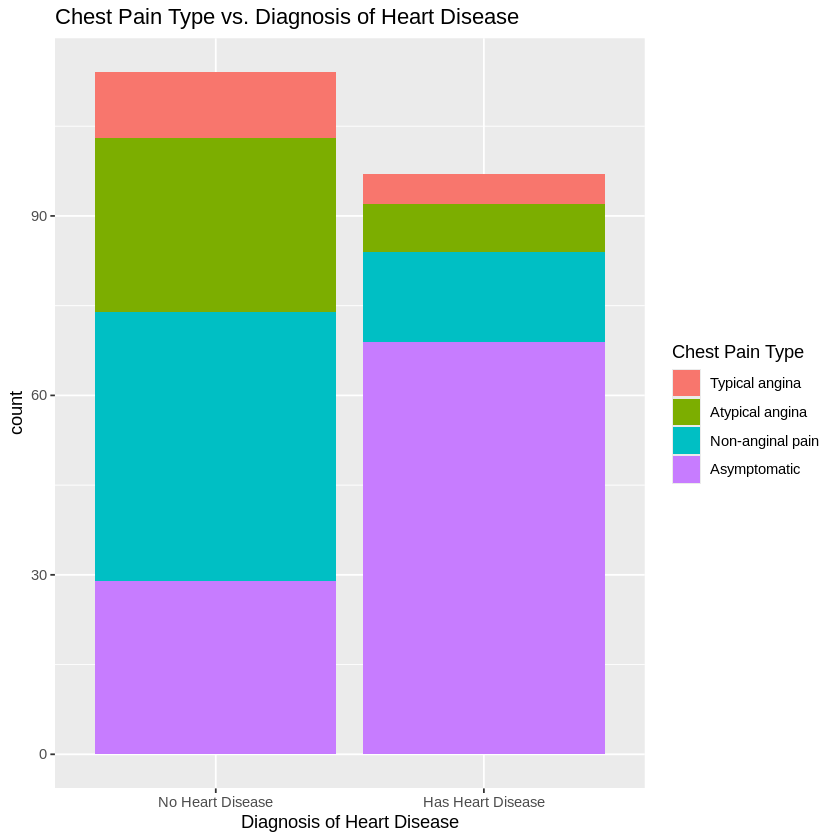

In [4]:
plot_1 <- hd_train |>
        mutate(
            cp = as_factor(cp),
            cp = fct_recode(cp, "Typical angina"="1", "Atypical angina"="2", "Non-anginal pain"="3", "Asymptomatic"="4")) |>
        group_by(cp, target) |>
        ggplot(aes(x = target, fill = cp)) +
        geom_histogram(stat = "count") +
        labs(x="Diagnosis of Heart Disease", fill="Chest Pain Type") +
        ggtitle("Chest Pain Type vs. Diagnosis of Heart Disease")
plot_1

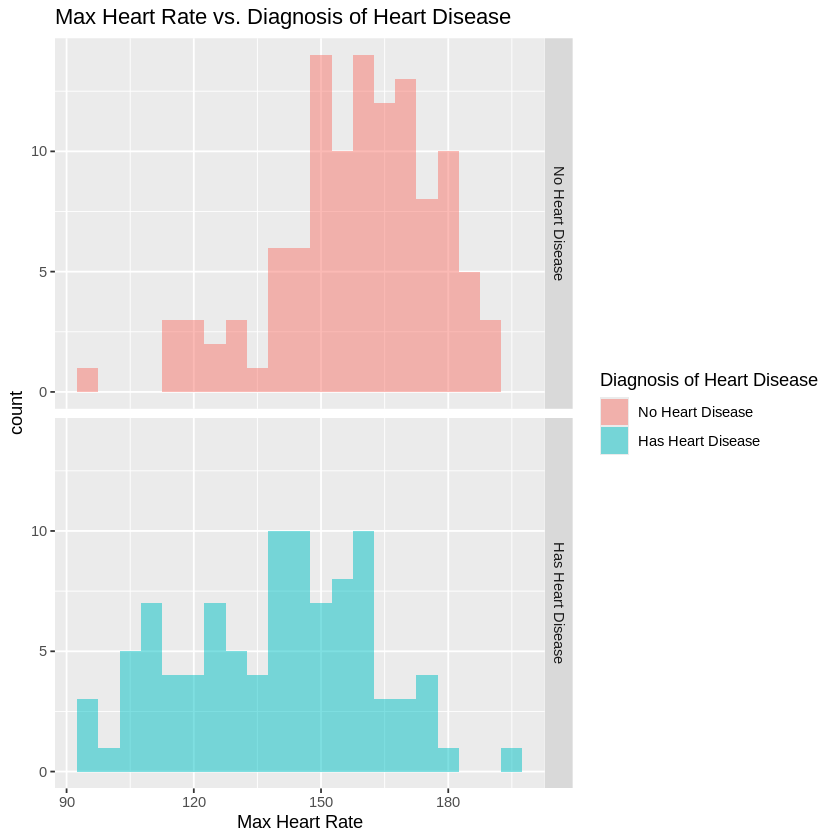

In [5]:
plot_2 <- hd_train |>
        ggplot(aes(x = thalach, fill = target)) +
        geom_histogram(alpha = 0.5, position="identity", bins = 30, binwidth = 5) +
        facet_grid(rows = vars(target)) +
        labs(x="Max Heart Rate", fill="Diagnosis of Heart Disease") +
        ggtitle("Max Heart Rate vs. Diagnosis of Heart Disease")
plot_2

Warning message in geom_histogram(stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


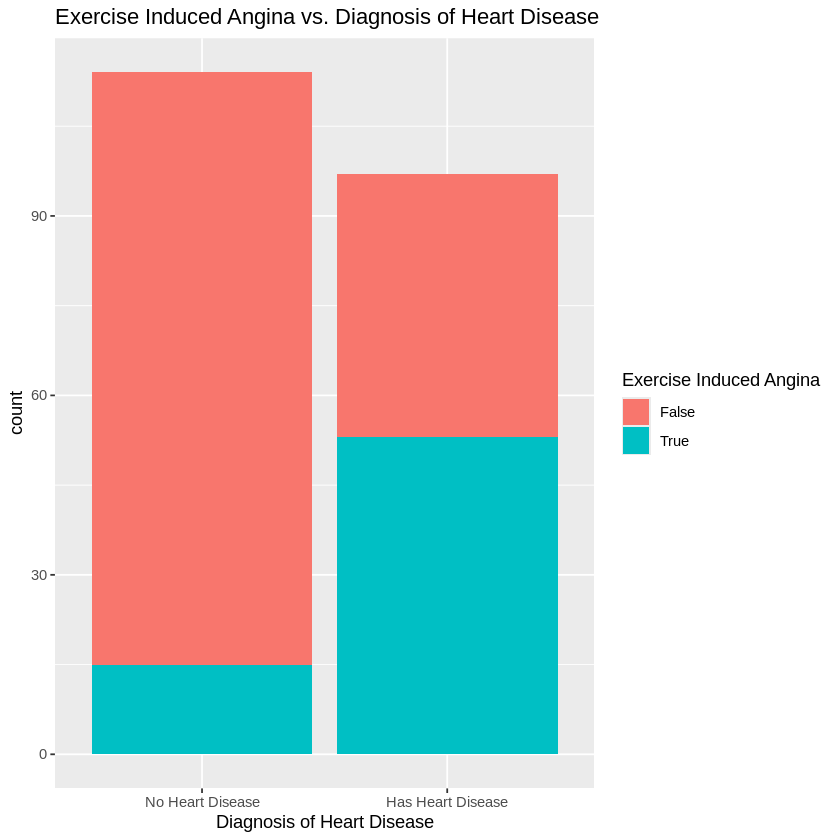

In [6]:
plot_3 <- hd_train |>
        mutate(
            exang = as_factor(exang),
            exang = fct_recode(exang, "True"="1", "False"="0")) |>
        ggplot(aes(x = target, fill = exang)) +
        geom_histogram(stat = "count") +
        labs(x="Diagnosis of Heart Disease", fill="Exercise Induced Angina") +
        ggtitle("Exercise Induced Angina vs. Diagnosis of Heart Disease")
plot_3

### Hyperparameter Optimization

In [30]:
# hd_train
knn_tune_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_recipe <- recipe(target ~ ., data = hd_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

hd_fold <- vfold_cv(hd_train, v = 6, strata = target)

In [31]:
knn_tune <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_tune_spec) |>
    tune_grid(resamples = hd_fold, 
              grid = k_vals,
              control = control_resamples(save_pred = TRUE))

In [32]:
knn_tune_accuracy <- knn_tune |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    mutate(accuracy = mean) |>
    select(neighbors, accuracy) 

In [33]:
knn_tune_recall <- knn_tune |>
    collect_predictions() |>
    group_by(neighbors, id) |>
    recall(truth = target, .pred_class, event_level="second") |>
    group_by(neighbors) |>
    summarize(
        recall = mean(.estimate)) |>
    select(recall)

knn_tune_metrics <- knn_tune_accuracy |>
    bind_cols(knn_tune_recall)

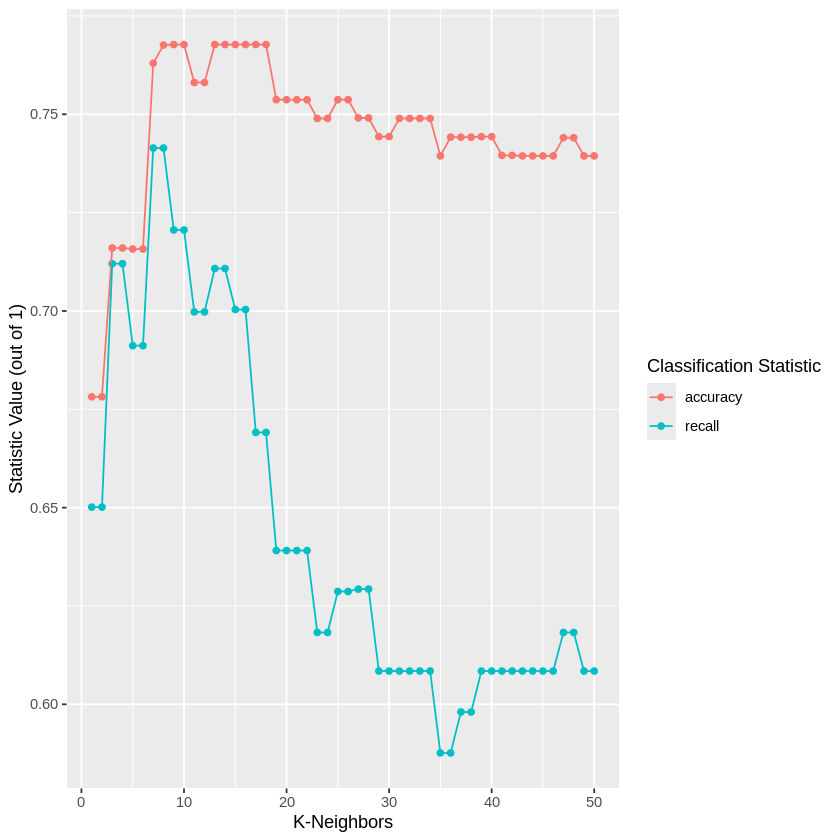

In [34]:
knn_tune_plot <- knn_tune_metrics |>
    pivot_longer(cols = accuracy:recall, names_to = "stats", values_to = "values") |>
    ggplot(aes(x = neighbors, y = values, color = stats)) +
    geom_point() +
    geom_line() +
    labs(x = "K-Neighbors",
         y = "Statistic Value (out of 1)",
         color = "Classification Statistic")

knn_tune_plot

Figure 3. Mean Accuracy and Mean Recall from Cross-Validation Testing vs. K-Neighbors

### Evaluating the Model

In [35]:
best_k = 7

knn_spec_final <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit_final <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_spec_final) |>
    fit(data = hd_train)

knn_predict_final <- knn_fit_final |>
    predict(hd_test) |>
    bind_cols(hd_test)

knn_metric_final <- knn_predict_final |>
    metrics(truth = target, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    add_row(recall(knn_predict_final, truth = target, estimate = .pred_class, event_level="second")) |>
    select(.metric, .estimate)

knn_metric_final

.metric,.estimate
<chr>,<dbl>
accuracy,0.7934783
recall,0.8095238


Table 4. Classification Statistics of the Testing Dataset 

## Discussion

I expect to find that heart rate and exercise-induced angina would be good predictors in heart disease diagnosis. I also expected that there will be a difference due to sex, but not age. Initially, I picked these predictors as there were easy to determine and does not require the patient to undergo additional testing. If high performing model can be found using these predictors, the impact of these findings could aid in early diagnosis of heart disease and gives doctors more time to find a treatment that works for the patient.

Future direction for this data analysis would include:
    1. How applicable are these predictors to other countries, namely in regions where fast food stores are more scarce?
    2. Could AI be used to accurately predict heart disease in American patients?

summarize what you found
discuss whether this is what you expected to findto?